In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
emb = pl.read_parquet("../data/image_embeddings.parquet")

In [3]:
emb

yad_no,category,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,…,emb_475,emb_476,emb_477,emb_478,emb_479,emb_480,emb_481,emb_482,emb_483,emb_484,emb_485,emb_486,emb_487,emb_488,emb_489,emb_490,emb_491,emb_492,emb_493,emb_494,emb_495,emb_496,emb_497,emb_498,emb_499,emb_500,emb_501,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,"""exterior""",-0.010736,-0.055452,-0.034968,0.052371,0.013423,0.037117,0.098775,0.074732,0.063942,-0.006076,-0.010779,-0.047442,-0.019652,-0.047359,-0.020234,0.001028,0.047164,-0.005473,-0.002038,0.006693,-0.023502,-0.01422,-0.006987,0.026753,-0.028943,-0.053034,-0.023145,-0.051321,0.053929,0.01521,0.027167,0.024862,0.027658,0.076914,0.037609,…,-0.030419,-0.011956,-0.025728,-0.007233,0.010292,-0.020596,0.045383,0.03378,0.008087,-0.045497,0.057276,0.028963,-0.062223,-0.02421,-0.043702,-0.009216,-0.050647,-0.02458,0.024108,0.02504,-0.037786,0.001092,-0.041541,-0.056678,0.01267,0.073731,0.02668,-0.039645,0.04795,-0.001786,-0.054268,-0.173725,-0.037862,-0.039419,0.039463,-0.071842,-0.007374
1,"""exterior""",0.056188,-0.026121,-0.056543,0.022742,-0.04626,0.020954,0.006757,-0.010403,-0.026507,0.019058,-0.026094,-0.017403,0.026993,-0.00108,-0.018597,0.017813,0.12091,-0.02644,-0.016452,-0.000818,-0.02413,0.004908,-0.017805,0.042187,-0.012755,0.018122,0.028844,-0.017643,0.059488,-0.029633,0.038601,0.083943,0.004442,-0.014696,-0.051,…,-0.039679,-0.019323,0.036515,0.057922,-0.037983,0.006651,0.084392,-0.056245,-0.008736,0.021267,-0.055239,-0.065042,-0.008895,-0.001312,-0.007665,0.011888,0.045842,-0.013663,-0.079298,0.000089,-0.06487,-0.016174,-0.014441,-0.021501,0.054347,0.075168,0.005903,-0.001135,0.019452,-0.158739,0.069106,-0.314221,-0.014093,0.020678,0.058678,0.027612,-0.00779
1,"""exterior""",0.059149,0.007443,-0.050527,0.031444,-0.034918,0.018043,0.016075,-0.000287,-0.009426,0.039171,-0.036332,-0.018064,0.026979,-0.036644,-0.011032,0.022314,0.110439,-0.041985,-0.012544,-0.001695,-0.033044,-0.018836,-0.040453,0.028967,-0.021594,-0.001497,0.027579,-0.01569,0.056139,-0.034785,0.02454,0.034075,-0.00396,-0.028511,-0.053675,…,-0.024465,-0.031229,0.030371,0.050534,-0.052374,0.011259,0.102311,-0.044944,0.000484,-0.013229,-0.037338,-0.00702,-0.019342,-0.004188,-0.010752,0.042154,0.02971,-0.00991,-0.0492,-0.022146,-0.048599,-0.032585,-0.005564,-0.011832,0.055496,0.056817,0.007745,-0.017606,0.028306,-0.153259,0.079555,-0.30552,-0.034372,0.037976,0.065278,0.023551,-0.00677
1,"""facility""",-0.008016,0.031106,-0.01394,0.013397,-0.025822,0.020344,0.049135,-0.031101,-0.019041,0.022803,0.023066,0.002165,-0.019646,-0.021939,-0.009514,-0.031552,0.024221,0.011428,-0.020659,0.015083,-0.010904,-0.042875,-0.00325,0.041042,-0.003044,0.026467,-0.043559,-0.035735,0.01363,-0.007093,0.01281,0.011995,-0.020125,-0.025706,-0.026747,…,-0.015534,-0.033803,-0.005863,0.018898,0.001998,-0.033391,0.083921,-0.015852,0.006281,0.00476,-0.001234,0.102019,-0.013007,0.034236,-0.023143,-0.020034,0.054738,-0.018876,-0.012832,0.011145,-0.015147,0.00897,0.002016,-0.044897,-0.032774,-0.016944,0.076967,-0.029366,-0.035536,-0.098193,0.031702,-0.359215,-0.041691,0.002394,-0.022892,-0.039722,-0.01338
1,"""facility""",0.010669,-0.000045,0.002484,0.008006,-0.041051,0.02213,0.026998,0.011513,-0.01262,-0.005671,0.001992,-0.028685,0.006872,-0.023326,0.008831,-0.06205,0.088245,0.002428,-0.001147,0.014356,0.001457,-0.008756,0.022027,0.091676,0.003202,-0.011972,0.008096,-0.019465,0.025329,-0.006433,-0.027086,0.041115,-0.013291,-0.0266,-0.038509,…,-0.018135

In [4]:
emb.group_by(["category"]).count()

category,count
str,u32
"""room""",36989
"""facility""",36932
"""food""",33282
"""others""",34104
"""exterior""",37099


In [78]:
image_n_orig_cat = (emb.group_by(["yad_no", "category"]).count().sort("yad_no").pivot(values="count", index="yad_no", columns="category").fill_null(0)
     .rename({"food": "image_n_food", 
              "exterior":"image_n_exterior", 
              "others": "imege_n_others", 
              "facility": "imege_n_facility",
              "room": "imege_n_room",})
)

In [5]:
emb.select(pl.col("^emb.+$"))

emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,…,emb_475,emb_476,emb_477,emb_478,emb_479,emb_480,emb_481,emb_482,emb_483,emb_484,emb_485,emb_486,emb_487,emb_488,emb_489,emb_490,emb_491,emb_492,emb_493,emb_494,emb_495,emb_496,emb_497,emb_498,emb_499,emb_500,emb_501,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-0.010736,-0.055452,-0.034968,0.052371,0.013423,0.037117,0.098775,0.074732,0.063942,-0.006076,-0.010779,-0.047442,-0.019652,-0.047359,-0.020234,0.001028,0.047164,-0.005473,-0.002038,0.006693,-0.023502,-0.01422,-0.006987,0.026753,-0.028943,-0.053034,-0.023145,-0.051321,0.053929,0.01521,0.027167,0.024862,0.027658,0.076914,0.037609,0.036482,0.106742,…,-0.030419,-0.011956,-0.025728,-0.007233,0.010292,-0.020596,0.045383,0.03378,0.008087,-0.045497,0.057276,0.028963,-0.062223,-0.02421,-0.043702,-0.009216,-0.050647,-0.02458,0.024108,0.02504,-0.037786,0.001092,-0.041541,-0.056678,0.01267,0.073731,0.02668,-0.039645,0.04795,-0.001786,-0.054268,-0.173725,-0.037862,-0.039419,0.039463,-0.071842,-0.007374
0.056188,-0.026121,-0.056543,0.022742,-0.04626,0.020954,0.006757,-0.010403,-0.026507,0.019058,-0.026094,-0.017403,0.026993,-0.00108,-0.018597,0.017813,0.12091,-0.02644,-0.016452,-0.000818,-0.02413,0.004908,-0.017805,0.042187,-0.012755,0.018122,0.028844,-0.017643,0.059488,-0.029633,0.038601,0.083943,0.004442,-0.014696,-0.051,0.034442,-0.032401,…,-0.039679,-0.019323,0.036515,0.057922,-0.037983,0.006651,0.084392,-0.056245,-0.008736,0.021267,-0.055239,-0.065042,-0.008895,-0.001312,-0.007665,0.011888,0.045842,-0.013663,-0.079298,0.000089,-0.06487,-0.016174,-0.014441,-0.021501,0.054347,0.075168,0.005903,-0.001135,0.019452,-0.158739,0.069106,-0.314221,-0.014093,0.020678,0.058678,0.027612,-0.00779
0.059149,0.007443,-0.050527,0.031444,-0.034918,0.018043,0.016075,-0.000287,-0.009426,0.039171,-0.036332,-0.018064,0.026979,-0.036644,-0.011032,0.022314,0.110439,-0.041985,-0.012544,-0.001695,-0.033044,-0.018836,-0.040453,0.028967,-0.021594,-0.001497,0.027579,-0.01569,0.056139,-0.034785,0.02454,0.034075,-0.00396,-0.028511,-0.053675,0.041953,-0.01896,…,-0.024465,-0.031229,0.030371,0.050534,-0.052374,0.011259,0.102311,-0.044944,0.000484,-0.013229,-0.037338,-0.00702,-0.019342,-0.004188,-0.010752,0.042154,0.02971,-0.00991,-0.0492,-0.022146,-0.048599,-0.032585,-0.005564,-0.011832,0.055496,0.056817,0.007745,-0.017606,0.028306,-0.153259,0.079555,-0.30552,-0.034372,0.037976,0.065278,0.023551,-0.00677
-0.008016,0.031106,-0.01394,0.013397,-0.025822,0.020344,0.049135,-0.031101,-0.019041,0.022803,0.023066,0.002165,-0.019646,-0.021939,-0.009514,-0.031552,0.024221,0.011428,-0.020659,0.015083,-0.010904,-0.042875,-0.00325,0.041042,-0.003044,0.026467,-0.043559,-0.035735,0.01363,-0.007093,0.01281,0.011995,-0.020125,-0.025706,-0.026747,0.046042,-0.018189,…,-0.015534,-0.033803,-0.005863,0.018898,0.001998,-0.033391,0.083921,-0.015852,0.006281,0.00476,-0.001234,0.102019,-0.013007,0.034236,-0.023143,-0.020034,0.054738,-0.018876,-0.012832,0.011145,-0.015147,0.00897,0.002016,-0.044897,-0.032774,-0.016944,0.076967,-0.029366,-0.035536,-0.098193,0.031702,-0.359215,-0.041691,0.002394,-0.022892,-0.039722,-0.01338
0.010669,-0.000045,0.002484,0.008006,-0.041051,0.02213,0.026998,0.011513,-0.01262,-0.005671,0.001992,-0.028685,0.006872,-0.023326,0.008831,-0.06205,0.088245,0.002428,-0.001147,0.014356,0.001457,-0.008756,0.022027,0.091676,0.003202,-0.011972,0.008096,-0.019465,0.025329,-0.006433,-0.027086,0.041115,-0.013291,-0.0266,-0.038509,-0.003042,-0.01356,…,-0.

In [13]:
emb.filter(pl.col("yad_no")%30==0).select(pl.col("^emb.+$"))

emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,…,emb_475,emb_476,emb_477,emb_478,emb_479,emb_480,emb_481,emb_482,emb_483,emb_484,emb_485,emb_486,emb_487,emb_488,emb_489,emb_490,emb_491,emb_492,emb_493,emb_494,emb_495,emb_496,emb_497,emb_498,emb_499,emb_500,emb_501,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.024022,-0.018532,0.011669,0.005919,-0.005931,0.023423,-0.023231,-0.01987,-0.052345,-0.039763,-0.008181,-0.031986,0.070162,-0.027355,-0.034265,0.010671,0.052831,-0.021046,-0.021144,-0.035768,0.015303,0.031595,-0.016354,-0.066324,-0.016534,-0.00022,0.024687,0.035093,-0.010158,0.02866,0.013034,-0.026033,0.015695,0.028336,-0.009189,0.014417,0.014486,…,-0.040606,0.019778,0.032973,-0.000108,-0.029692,0.007813,0.075671,0.025679,-0.031694,-0.008153,0.006386,-0.048883,-0.024412,-0.00632,0.015702,0.022153,0.00366,-0.008499,-0.054276,-0.019378,-0.01376,0.017608,-0.015749,-0.004497,0.037054,0.024687,-0.036218,-0.001385,-0.002173,-0.060548,0.058172,-0.307356,-0.057563,0.01039,0.027714,0.012517,0.021483
0.06091,-0.026118,-0.021032,-0.0042,0.021948,0.013982,0.010494,-0.031302,-0.025973,-0.018553,-0.023031,-0.006498,0.050252,-0.008258,-0.006491,0.035936,0.151553,0.004257,-0.023089,-0.050289,0.020704,-0.034627,0.0022,-0.08696,-0.005745,-0.011805,0.049767,0.025535,-0.004522,0.015763,-0.013147,0.005658,-0.02187,0.013699,-0.014341,-0.007271,-0.004213,…,0.011111,0.009635,0.050963,0.010478,-0.024468,-0.017054,0.108872,0.023764,0.008333,-0.03331,-0.012324,-0.079358,0.032445,0.014112,0.017562,-0.014429,0.003035,-0.023959,-0.027057,-0.004811,0.009392,0.026581,-0.026291,0.014924,0.026666,0.033494,-0.019874,-0.004957,0.006286,-0.10835,0.048177,-0.33613,-0.019296,-0.008538,0.044299,0.058222,0.065846
0.002247,-0.01645,0.005159,-0.015143,-0.03366,0.070805,0.024144,-0.001325,0.036937,0.033136,-0.008165,0.02584,-0.0019,0.028349,0.019877,-0.017787,-0.007891,-0.035835,-0.035456,0.061333,0.003519,0.001136,-0.038224,0.040234,0.006685,0.01948,0.009476,-0.010918,-0.029585,0.038479,0.031542,-0.047049,0.050042,-0.040242,0.002756,0.021337,0.011449,…,0.004376,0.043785,0.030588,0.063526,0.01292,0.019455,-0.001987,0.024767,-0.028553,0.069173,0.041732,0.036391,-0.004884,0.043717,-0.023873,-0.037173,0.025314,-0.012125,-0.004132,-0.029883,-0.000087,-0.037564,0.003085,0.052318,0.033303,-0.00152,0.013673,0.018808,0.008291,-0.067743,0.002091,-0.292034,-0.071056,0.012294,0.073371,0.009748,0.044404
0.003777,0.020824,-0.019254,0.033508,-0.074909,-0.025488,0.036774,0.009767,0.03666,-0.014013,-0.022266,0.029865,0.050373,-0.0347,0.037591,-0.013867,0.028241,-0.022159,-0.019696,0.008881,0.02216,-0.021639,0.005786,0.10657,-0.02498,0.004879,0.046456,-0.018901,0.017637,0.021895,-0.036229,-0.028387,0.010171,0.001429,-0.002243,0.010789,0.017159,…,-0.005481,0.040587,0.025731,-0.040527,0.034219,-0.041443,-0.02953,-0.004498,-0.001124,-0.03172,0.008303,0.004491,-0.014683,0.029405,-0.045771,0.013924,0.029691,-0.011996,-0.011486,-0.004015,0.015995,-0.035432,0.012708,0.025423,0.037881,0.009224,0.046186,-0.003991,-0.023854,-0.108173,0.019036,-0.357464,-0.028883,-0.000413,0.011911,-0.016352,0.017904
0.035474,0.001759,0.022133,-0.043561,-0.000948,0.048792,0.048389,-0.028244,0.049642,0.027529,0.021085,0.012638,0.004953,0.007312,0.018734,-0.036632,0.011296,0.000584,-0.029286,0.045625,-0.032206,-0.017675,-0.019936,0.075781,-0.013715,-0.013747,-0.008425,-0.028338,0.022582,-0.005873,0.020456,-0.056408,-0.045044,-0.010765,-0.009388,0.000598,-0.018138,…,0.0413,0.00228,-0.009

In [59]:


#t-SNEで次元削減
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
emb_downsample = emb.filter(pl.col("yad_no")%10==0)
X_embedded = tsne.fit_transform(emb_downsample.select(pl.col("^emb.+$")))

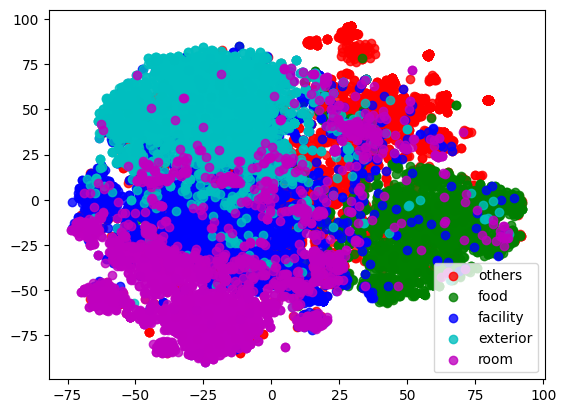

In [60]:


colors =  ["r", "g", "b", "c", "m", "y", "k", "orange", "pink"]

for i, v in enumerate(emb["category"].unique()):
    plt.scatter(X_embedded[emb_downsample["category"] == v][:, 0], X_embedded[emb_downsample["category"] == v][:, 1], 
                c=colors[i], 
                label=v, alpha=0.8)
    plt.legend()


# colors =  ["r", "g", "b", "c", "m", "y", "k", "orange", "pink"]
# plt.figure(figsize = (30, 30))
# for i, v in enumerate(article_list):
#     tmp_df = ddf[ddf[1] == v]
#     plt.scatter(tmp_df['col1'],  
#                 tmp_df['col2'],
#                 label = v,
#                 color = colors[i])


In [110]:
import sklearn.cluster
clustered = sklearn.cluster.k_means(emb.select(pl.col("^emb.+$")), 10)[1]

/home/morim/repos/datascience/atmacup16/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [111]:
np.save("../data/features/features_image_cluster.npy", clustered)

In [112]:
for i in range(30):
    plt.scatter(X_embedded[clustered == i][:, 0], X_embedded[clustered == i][:, 1], 
                alpha=0.8)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 17823 but corresponding boolean dimension is 178406

In [ ]:
clustered[:12]

In [114]:
image_n_cluster = (
    pl.DataFrame({
    "yad_no": emb["yad_no"], 
    "cluster": clustered
}).group_by(["yad_no", "cluster"]).count().pivot(values="count", index="yad_no", columns="cluster", ).fill_null(0)
)

for i in range(10):
    image_n_cluster = image_n_cluster.rename({f"{i}": f"image_cluster_{i}"})


In [116]:
image_features = image_n_orig_cat.join(image_n_cluster, how="left", on="yad_no")

In [117]:
image_features

yad_no,image_n_food,imege_n_others,image_n_exterior,imege_n_room,imege_n_facility,image_cluster_4,image_cluster_0,image_cluster_5,image_cluster_6,image_cluster_2,image_cluster_9,image_cluster_7,image_cluster_3,image_cluster_1,image_cluster_8
i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1,3,2,3,3,3,3,3,0,0,0,3,2,0,3,0
2,3,2,3,1,3,3,3,1,1,0,0,1,2,1,0
3,3,2,3,3,1,1,2,0,1,0,1,4,0,3,0
4,3,2,3,1,3,2,0,4,0,0,3,2,0,1,0
5,3,3,3,3,3,3,3,3,1,0,3,0,2,0,0
6,3,2,3,2,3,0,3,1,5,1,0,0,2,1,0
7,0,3,1,3,3,4,0,0,1,0,2,3,0,0,0
8,1,3,3,3,3,4,1,2,1,0,1,3,0,1,0
9,3,1,3,3,3,4,1,0,2,0,0,3,0,2,1


In [119]:
image_features.write_parquet("../data/features/features_image_cluster.parquet")

In [120]:
top20 = pl.read_parquet("../data/candidates/train_latest_next_booking_top20_candidates.parquet")

In [124]:
top20.sort("yad_no").unique("yad_no")

yad_no,latest_yad_no,fold
i64,i64,i32
1,6431,3
2,36,0
3,420,0
4,430,0
5,117,0
6,7354,0
7,3067,1
8,8649,0
9,728,0


In [125]:
train_label = pl.read_parquet("../data/train_label.parquet")

In [129]:
train_label.unique("yad_no").sort("yad_no")

session_id,yad_no
str,i64
"""65b78d0627f5e5…",1
"""166aa34e80b8e8…",2
"""09bee7c566c4fe…",3
"""0ed6adfc01b805…",4
"""09c5c910382b54…",5
"""a032f35c9654d6…",6
"""135fa75722ab3b…",7
"""22cea7fc289af7…",8
"""01dbc96dc41b60…",9


In [26]:

train_log = pl.read_parquet("../data/train_log.parquet")
train_label = pl.read_parquet("../data/train_label_cv.parquet")
yado_df = pl.read_parquet("../data/yado.parquet")


candidate = pl.read_parquet(
    '../data/candidates/train_top10_sml_popular_yado_candidates.parquet')
from tqdm import tqdm
candidate_all = pl.DataFrame()
for fold in range(5):
    train_areas = train_log.join(yado_df[["yad_no", "sml_cd"]], on = "yad_no", how = "left").sort("seq_no", descending=True).join(train_label[["session_id", "fold"]], on="session_id", how="left").filter(pl.col('fold') == fold)
    train_areas = train_areas.unique(["session_id", "sml_cd"])[["session_id", "sml_cd"]]
    candidate_fold = train_areas.join(candidate, how="left", on="sml_cd")[["session_id", "yad_no"]]
    # for s, d in tqdm(train_areas.group_by("session_id")):
    #     for sml_cd in d["sml_cd"].unique().to_list():
    #         candidate_fold += [
    #             yad for yad in candidate.filter(pl.col("sml_cd") == sml_cd)["yad_no"].to_list()
    #         ]

    candidate_all = pl.concat(
        [candidate_all, candidate_fold])

shape: (2_973_512, 2)
┌──────────────────────────────────┬────────┐
│ session_id                       ┆ yad_no │
│ ---                              ┆ ---    │
│ str                              ┆ i64    │
╞══════════════════════════════════╪════════╡
│ 4922a26953a9982fcaf8623dd73f30f5 ┆ 719    │
│ 4922a26953a9982fcaf8623dd73f30f5 ┆ 8567   │
│ 4922a26953a9982fcaf8623dd73f30f5 ┆ 2201   │
│ 4922a26953a9982fcaf8623dd73f30f5 ┆ 5116   │
│ …                                ┆ …      │
│ ffe9fd65ee164883006be2dc5c337f90 ┆ 1868   │
│ ffe9fd65ee164883006be2dc5c337f90 ┆ 5372   │
│ ffe9fd65ee164883006be2dc5c337f90 ┆ 13323  │
│ ffe9fd65ee164883006be2dc5c337f90 ┆ 6655   │
└──────────────────────────────────┴────────┘
shape: (2_974_808, 2)
┌──────────────────────────────────┬────────┐
│ session_id                       ┆ yad_no │
│ ---                              ┆ ---    │
│ str                              ┆ i64    │
╞══════════════════════════════════╪════════╡
│ b41cff74cb0e1e423cf7fc40a8355d3f ┆

In [31]:
test_feature = pl.read_parquet("../data/features/X_test_20231213_20231213164423.parquet")

In [34]:
test_feature.unique("session_id").shape

(174700, 111)